<h1 style="font-size:30px;">Application: Watermarks</h1>

In this notebook, you are going to learn how to add watermarks to images. A watermark is typically a semi-transparent logo or message added to an image to convey some additional information. We will demonstrate how to create watermarks by first showing how to add a transparent logo to an image. Then we will take it a step further and show you how to blend a transparent logo with an image for a true "watermark" effect.

We will be working with the following logo and image to create watermarks.
![feature_image.jpg](https://opencv.org/wp-content/uploads/2021/08/c0-m2-watermark-feature-image.jpg)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (15, 15)

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/f8ae3j0nbrflife/AAAy-WwcREtWOGgoEbFLDPANa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
else:
    pass


# 1. Adding a Transparent (PNG) Logo to an Image

This method works well with logos with both white and black backgrounds. Except this does not provide transparency effect. Here, we are going to learn how to use the `bitwise_and()` and `bitwise_not()` functions to carry out the operation.


### <font style="color:rgb(50,120,230)">Goal</font>

![watermarked_method_1](https://opencv.org/wp-content/uploads/2021/08/c0-m2-watermarked-method-1.jpg)
                                  

### <font style="color:rgb(50,120,230)">Workflow</font>
1. Adjust the size of the logo if required
2. Separate the color and alpha channels from the logo
3. Determine the region of interest (ROI) in the image for logo placement
4. Use logical operations to create ROI and logo masks
5. Use logical operations to combine the ROIs into a watermarked patch
6. Insert the watermark patch in the image

## 1.1 Read and Display the Images

Image size :  (730, 1094, 3)
Logo size :  (2436, 2623, 4)


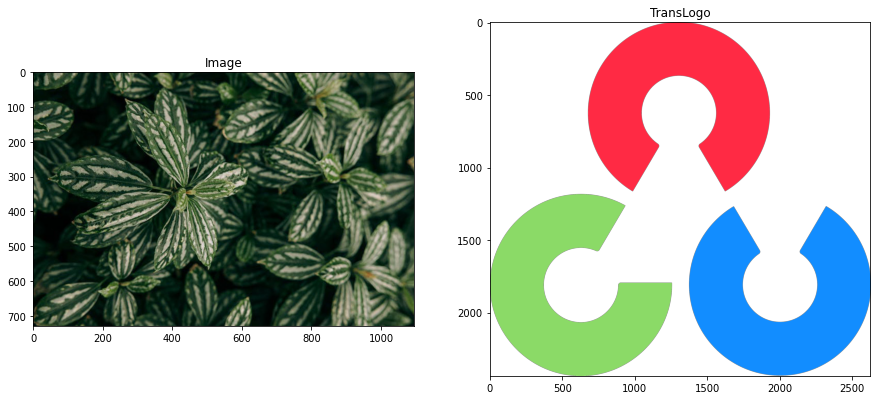

In [2]:
# Read the image and logo.
img = cv2.imread('leaves.jpg', cv2.IMREAD_UNCHANGED)
logo = cv2.imread('opencv_logo.png', cv2.IMREAD_UNCHANGED)

# Check the dimensions, noticing the channel counts.
print('Image size : ', img.shape)
print('Logo size : ', logo.shape)

# For ease of display below, convert to RGBA.
logo_rgba = cv2.cvtColor(logo, cv2.COLOR_BGRA2RGBA)

# Display the images.
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img[:, :, ::-1]); plt.title('Image');
plt.subplot(122); plt.imshow(logo_rgba);       plt.title('TransLogo');


## 1.2  Reduce the Size of the OpenCV Logo

### <font color="green">OpenCV Documentation</font>

[**`resize()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)

In [3]:
# Resize the logo to 10% of its original dimensions.
logo = cv2.resize(logo, None, fx = 0.1, fy = 0.1, interpolation = cv2.INTER_LINEAR)

# Retrieve the image and logo shapes.
img_h, img_w, _ = img.shape
logo_h, logo_w, _ = logo.shape

# Print the shape of the resized logo.
print(logo.shape)

(244, 262, 4)


## 1.3 Separate the Color and Alpha Channels

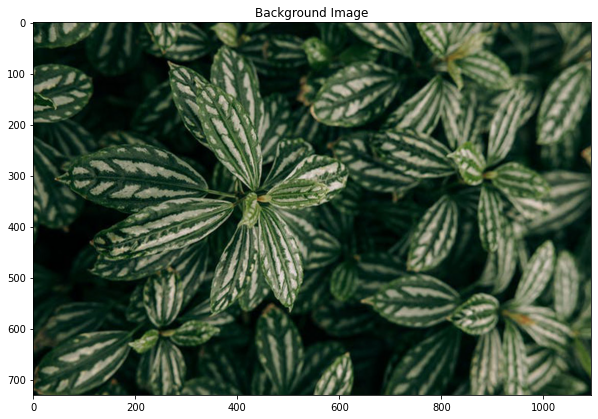

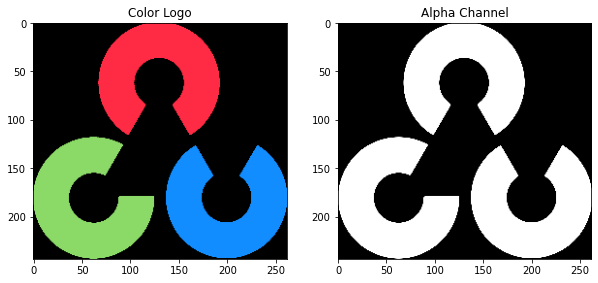

In [4]:
# Separate the color and alpha channels.
logo_bgr   = logo[:, :, 0:3]
logo_alpha = logo[:, :, 3]

# Dispay the images.
plt.figure(figsize = (10, 10))
plt.imshow(img[:, :, ::-1]); plt.title('Background Image');

plt.figure(figsize = (10, 5))
plt.subplot(121); plt.imshow(logo_bgr[:, :, ::-1]);  plt.title('Color Logo');
plt.subplot(122); plt.imshow(logo_alpha);            plt.title('Alpha Channel');

## 1.4 Determine the Region of Interest (ROI) in the Image
The region of interest (ROI) is the area on which we are going to superimpose the logo. In this example, we are going to place the logo in the center of the image. The following figure illustrates the coordinates used in the code below.<br>
![ROI_Coordinates](https://opencv.org/wp-content/uploads/2021/08/c0-m2-ROI-Coordinates.png)

### <font style="color:rgb(50,120,230)">Place the logo at the center of the image</font>

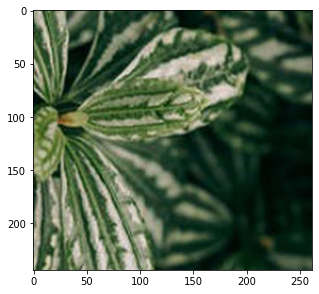

In [5]:
# Cx and Cy are center of the image.
cx = int(img_w/2)
cy = int(img_h/2)

# tlc : top left corner.
tlc_x = int(cx - logo_w/2)
tlc_y = int(cy - logo_h/2)

# brc : bottom right corner.
brc_x = int(cx + logo_w/2)
brc_y = int(cy + logo_h/2)

# Get region of interest from the original image.
roi = img[tlc_y:brc_y, tlc_x:brc_x]

# Display the ROI.
plt.figure(figsize = (5, 5))
plt.imshow(roi[:, :, ::-1]);

## 1.5 Create ROI Masked Outputs

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`bitwise_and()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14)
[**`bitwsie_not()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga0002cf8b418479f4cb49a75442baee2f)
[**`bitwise_or()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gab85523db362a4e26ff0c703793a719b4)

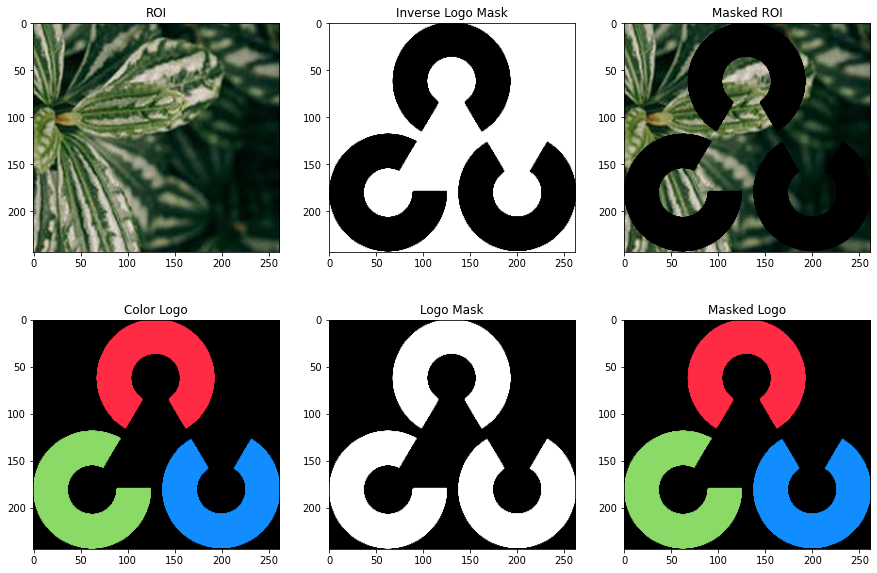

In [6]:
# Make the dimensions of the mask same as the input image.
# Since the background image is a 3-channel image, we create a 3 channel image for the mask.
logo_mask = cv2.merge([logo_alpha, logo_alpha, logo_alpha])

logo_mask_inv = cv2.bitwise_not(logo_mask)

# Use the mask to create the masked ROI region.
masked_roi = cv2.bitwise_and(roi, logo_mask_inv)

# Use the mask to create the masked logo region.
masked_logo = cv2.bitwise_and(logo_bgr, logo_mask)

# Display the intermediate results.
plt.figure(figsize = [15, 10])

plt.subplot(231); plt.imshow(roi[:, :, ::-1]);           plt.title("ROI");
plt.subplot(232); plt.imshow(logo_mask_inv[:, :, ::-1]); plt.title("Inverse Logo Mask");
plt.subplot(233); plt.imshow(masked_roi[:, :, ::-1]);    plt.title("Masked ROI");

plt.subplot(234); plt.imshow(logo_bgr[:, :, ::-1]);      plt.title("Color Logo");
plt.subplot(235); plt.imshow(logo_mask[:, :, ::-1]);     plt.title("Logo Mask");
plt.subplot(236); plt.imshow(masked_logo[:, :, ::-1]);   plt.title("Masked Logo");

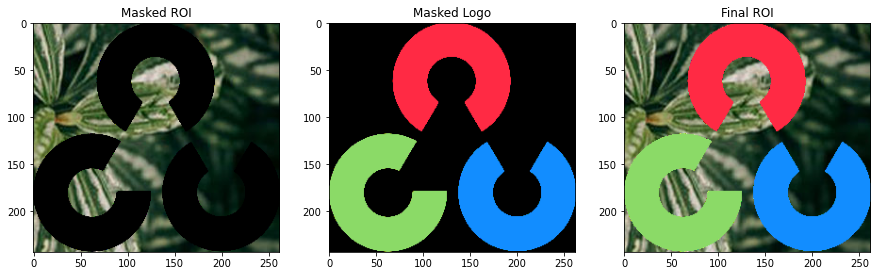

In [7]:
# Combine the masked ROI with the masked logo to get the combined ROI image.
roi_final = cv2.bitwise_or(masked_roi, masked_logo)

# Display the intermediate results.
plt.figure(figsize = [15, 10])

plt.subplot(131); plt.imshow(masked_roi[:,:,::-1]);  plt.title("Masked ROI");
plt.subplot(132); plt.imshow(masked_logo[:,:,::-1]); plt.title("Masked Logo");
plt.subplot(133); plt.imshow(roi_final[:,:,::-1]);   plt.title("Final ROI");

## 1.6 Add the ROI Patch to the Image


### <font style="color:rgb(50,120,230)">Create ROI and image copies to preserve those images</font>

In [8]:
# Create a copy of the roi and image to keep the originals intact.
roi_1 = roi.copy()
img_1 = img.copy()

### <font style="color:rgb(50,120,230)">Insert the final ROI in the image</font>

True

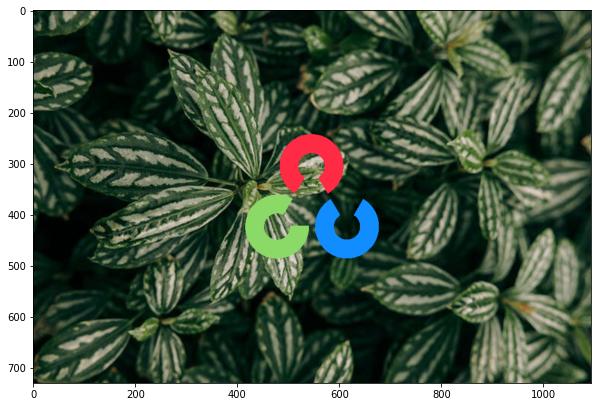

In [9]:
# Insert the ROI patch in the image.
img_1[tlc_y:brc_y, tlc_x:brc_x] = roi_final

# Display the image.
plt.figure(figsize = (10, 10))
plt.imshow(img_1[:, :, ::-1])

# Save the final watermakred image.
cv2.imwrite('watermarked_method_1.jpg', img_1)

# 2. Watermarking (adding a semi-transparent logo)

Now that we know how to make a straight forward watermark, let's take a look at another method which provides a transparency effect.

### <font style="color:rgb(50,120,230)">Goal</font>
![Water-marked-method2](https://opencv.org/wp-content/uploads/2021/08/c0-m2-watermarked-method-2.jpg)

### <font style="color:rgb(50,120,230)">Workflow</font>

**Note**: The first four steps were already completed in Section 1 above.

1. Adjust the size of the logo if required.
2. Separate the color and alpha channels from the logo.
3. Determine the region of interest (ROI) in the image for logo placement.
4. Use logical operations to create ROI and logo masks.


<hr   style='border:none; height: 4px; background-color: #D3D3D3'/>

Two additional steps are then taken for this alternate approach.

5. Use the `addWeighted()` function to blend the logo with the image ROI
6. Insert the watermark patch in the image


## 2.1 Superimpose the Logo with Image ROI

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

We are using `addWeighted()` function to put the watermarks. You can play with the values of beta to generate different results.
### <font color="green">Function Syntax </font>
``` python
dst = cv2.addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]])
```
`dst`: Is the output image of the same size and depth as `src1` and `src2`.

The function has **5 required arguments**:

1. `src`: first input array.
2. `alpha`: weight of the first array elements.
3. `src2`:	second input array.
4. `beta`: weight of the second array elements.
5. `gamma`: scalar added to each sum.

The function has **1 optional argument**:
1. `dtype` : optional depth of the output array; when both input arrays have the same depth, dtype can be set to -1, which will be equivalent to `src1.depth()`.

### <font color="green">OpenCV Documentation</font>

[**`addWeighted()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19)

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

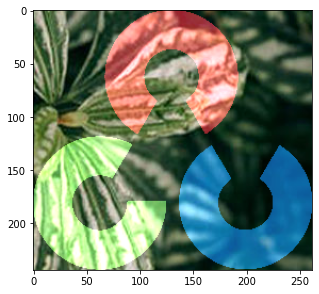

In [10]:
# Make a copy of the ROI.
roi_2 = roi.copy()

# Blend ROI and the logo.
watermarked = cv2.addWeighted(roi_2, 1, logo_bgr, 0.6, 0)

# Display the watermarked ROI.
plt.figure(figsize = (5, 5))
plt.imshow(watermarked[:, :, ::-1]);

# 2.2 Replace Image ROI Patch with Watermarked Patch

True

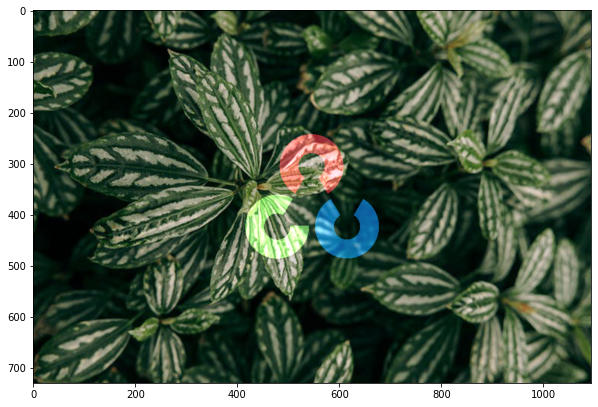

In [11]:
# Make a copy of the image.
img_2 = img.copy()

# Insert the watermarked ROI patch in the image.
img_2[tlc_y:brc_y, tlc_x:brc_x] = watermarked

# display
plt.figure(figsize = (10,10))
plt.imshow(img_2[:,:,::-1]);

# Save the image to the file system.
cv2.imwrite('watermarked_method_2.jpg',img_2)

## Comparing the methods

From the same source image and logo, we were able to create two different kinds of watermarks, which you can compare below.

![watermarked_method_1](https://opencv.org/wp-content/uploads/2021/08/c0-m2-watermarked-method-1.jpg)
![watermarked_method_2](https://opencv.org/wp-content/uploads/2021/08/c0-m2-watermarked-method-2.jpg)

There are many different ways to come up with the same results, and likewise, many different ways you could tweak the output. Possible extensions could include creating a repeating pattern where the logo is tiled multiplied times across the image, as well as automatically scaling the region of interest to make up a certain proportion of the original image being watermarked.